In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# dataset_name = 'juvenile'
# config_file = '../dataset_configs/juvenile_dataset.json'
dataset_name = 'juvenile_dfovf'
dataset_name = 'juvenile_noise_std0p2'
dataset_name = 'juvenile_noise_std0p5'
config_file = f'../../{dataset_name}_dataset/notebooks/{dataset_name}_dataset.json'

from analysis_config import juvenile_window_name_to_frames, juvenile_capacity_window_name_to_M, juvenile_capacity_window_name_to_seed
#window_name = 'time_window_3s'
#window_name = 'time_window_5s'
window_name = 'time_window_7s'
window = juvenile_window_name_to_frames[window_name]
print(window_name, window)
window_tag = f'window_{window[0]}to{window[1]}'

M = juvenile_capacity_window_name_to_M[window_name]
seed = juvenile_capacity_window_name_to_seed[window_name]


import os
fig_dir = f'../figures/{dataset_name}/{window_name}/capacity'
os.makedirs(fig_dir, exist_ok=True)


time_window_7s [32, 85]


In [12]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
rcParams['axes.linewidth'] = 0.5
rcParams['xtick.major.width'] = 0.5
rcParams['ytick.major.width'] = 0.5

In [13]:
import sys
import os
import pandas as pd
import numpy as np
from os.path import join as pjoin
from catrace.stats import sort_conditions, pool_training_conditions
from catrace.visualize import plot_measure, plot_all_measures

In [14]:
import sys
import os
import pandas as pd
from os.path import join as pjoin

from catrace.dataset import DatasetConfig
from catrace.utils import load_config

from catrace.dataset import load_dataset_config
window_key = f'window_{window[0]}_{window[1]}'
N=700 # number of neurons

dsconfig= load_dataset_config(config_file)
capacity_dir = os.path.join(dsconfig.results_dir, 'capacity')

jobname = f'capacity_sweep_{window_key}_N{N}_M{M}_master_seed{seed}'

# Load the capacity dataframe
import pandas as pd

input_dir = pjoin(capacity_dir, jobname)
exp_list = dsconfig.exp_list
conditions = dsconfig.conditions

# If file exists, load it
df_result_file = pjoin(input_dir, f'df_result.pkl')
df_result = pd.read_pickle(df_result_file)


def rename_odor_index_levels(df_per_fish):
    df_per_fish.reset_index(level=['odor_0', 'odor_1'], inplace=True)
    # Rename columns odor_0 to odor1 and odor_1 to odor2
    df_per_fish.rename(columns={'odor_0': 'odor1', 'odor_1': 'odor2'}, inplace=True)
    # Set odor1 and odor2 as index
    df_per_fish.set_index(['odor1', 'odor2'], inplace=True, append=True)
    return df_per_fish

df_per_fish_juv = df_result.xs(False, level='shuffle').groupby(['fish_id', 'condition', 'odor1', 'odor2'], sort=False).mean()
df_per_fish_juv_shuffled = df_result.xs(True, level='shuffle').groupby(['fish_id', 'condition', 'odor1', 'odor2'], sort=False).mean()

#df_per_fish_juv = rename_odor_index_levels(df_per_fish_juv)
#df_per_fish_juv_shuffled = rename_odor_index_levels(df_per_fish_juv_shuffled)

juv_conditions =  ['naive', 'arg-phe', 'phe-arg', 'phe-trp']
cond_mapping = {'naive': 'naive', 'phe-arg': 'trained', 'arg-phe': 'trained', 'phe-trp': 'trained'}
conditions_pooled = ['naive', 'trained']

df_pooled = pool_training_conditions(df_per_fish_juv, cond_mapping)

df_pooled_shuffled = pool_training_conditions(df_per_fish_juv_shuffled, cond_mapping)


## Juvenile
### All odor pairs

[('GCA', 'TDCA'), ('Phe', 'TCA'), ('Arg', 'Trp'), ('TCA', 'Trp'), ('Arg', 'GCA'), ('Phe', 'TDCA'), ('GCA', 'TCA'), ('TCA', 'TDCA'), ('Arg', 'TDCA'), ('GCA', 'Phe'), ('Arg', 'TCA'), ('GCA', 'Trp'), ('TDCA', 'Trp'), ('Arg', 'Phe'), ('Phe', 'Trp')]
    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   False        True  4.563466  203.472510   
1  condition  arg-phe  phe-arg   False        True -0.566950  220.460841   
2  condition  arg-phe  phe-trp   False        True  1.939852  222.146450   
3  condition    naive  phe-arg   False        True -7.172748  226.571506   
4  condition    naive  phe-trp   False        True -2.950203  178.000000   
5  condition  phe-arg  phe-trp   False        True  3.204203  187.919596   

  alternative         p-unc       BF10    hedges  
0   two-sided  8.694215e-06   1934.084  0.543841  
1   two-sided  5.713249e-01      0.152 -0.068649  
2   two-sided  5.366368e-02      0.863  0.240814  
3   two-sided  1.

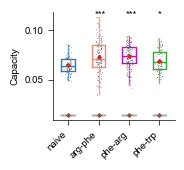

In [15]:
from catrace.stats import sort_conditions
from catrace.visualize import plot_measure_by_cond, PlotBoxplotByCondParams
from catrace.capacity_utils import get_group_vs_group
from dataclasses import replace

 # figsize=(4,6), ax_label_fontsize=22, xtick_label_fontsize=18, ytick_label_fontsize=16, star_fontsize=20, box_linewidth=4
def plot_stat_by_cond_with_shuffled(df_per_fish, df_per_fish_shuffled,
                                    conditions,
                                    with_shuffled=False, 
                                    plot_measure_params=PlotBoxplotByCondParams()):
    
    vsname = 'all_vs_all'
    odor1_group = ['Phe', 'Trp', 'Arg', 'TDCA', 'TCA', 'GCA']
    odor2_group = ['Phe', 'Trp', 'Arg', 'TDCA', 'TCA', 'GCA']

    dff = get_group_vs_group(df_per_fish, odor1_group, odor2_group)
    dff= sort_conditions(dff, conditions)


    fig, ax, test_results_raw = plot_measure_by_cond(dff, measure_name='capacity', test_type='kruskal', params=plot_measure_params)
    if with_shuffled:
        updated_params = replace(plot_measure_params,
                            box_color='darkgrey',
                            box_colors=None,
                            ylevel_scale=1.2,
                            mean_marker_color='tab:brown')
        dff_shuffled = get_group_vs_group(df_per_fish_shuffled, odor1_group, odor2_group)
        dff_shuffled = sort_conditions(dff_shuffled, conditions)
        fig, ax, test_results_shuffled = plot_measure_by_cond(dff_shuffled, measure_name='capacity', test_type='kruskal', ax=ax, params=updated_params)
    return fig, test_results_raw, test_results_shuffled

juv_conditions = dsconfig.conditions

color_dict = {'naive': 'tab:blue', 
              'arg-phe': 'salmon',
              'phe-arg': 'm',
              'phe-trp': 'tab:green',
}
plot_measure_params = PlotBoxplotByCondParams(
    figsize=(2.0, 1.8),
    box_linewidth=1,
    mean_marker_size=0.7,
    strip_size=0.5,
    ylim=None, #(0, 0.18),
    pvalue_marker_xoffset=0.2,
    box_colors= color_dict.values(),
    #['tab:blue', 'tab:brown', 'tab:green', 'tab:pink'],#['tab:blue', 'tab:orange'],
    ylevel_scale=0.95,
)
fig, test_results_raw, test_results_shuffled = plot_stat_by_cond_with_shuffled(df_per_fish_juv, df_per_fish_juv_shuffled, juv_conditions, with_shuffled=True, plot_measure_params=plot_measure_params)
import json
print(json.dumps(test_results_raw, indent=4))
from catrace.visualize import set_yticks_interval
set_yticks_interval(fig.get_axes()[0], 0.05)

In [16]:
from catrace.for_paper import save_figure_for_paper, save_stats_json
measure_name = 'capacity'
vsname = 'all_odors'
figname = f'{dataset_name}_{vsname}_{measure_name}_per_cond_window_{window_key}'
save_figure_for_paper(fig, figname, fig_dir)


In [17]:
fig_dir

'../figures/juvenile_noise_std0p5/time_window_7s/capacity'

In [18]:
from catrace.stats import format_test_results_by_cond
sentence = format_test_results_by_cond(test_results_raw)
print('raw')
print(sentence)


sentence = format_test_results_by_cond(test_results_shuffled)
print('shuffled')
print(sentence)

raw
(Kruskal–Wallis test, n = 465, d.f. = 3, H = 38.85, P = 1.9 × 10^-8). Group statistics: arg-phe: mean = 0.0732 ± 0.0179 (n = 135); naive: mean = 0.0651 ± 0.00837 (n = 90); phe-arg: mean = 0.0742 ± 0.0112 (n = 150); and phe-trp: mean = 0.0694 ± 0.0112 (n = 90). Nonparametric multiple comparisons against naive (n = 90): arg-phe, Q = 4.56, P = 2.6 × 10^-5, n = 90; phe-arg, Q = 7.17, P = 3.1 × 10^-11, n = 150; and phe-trp, Q = 2.95, P = 0.011, n = 90.
shuffled
(Kruskal–Wallis test, n = 465, d.f. = 3, H = 1.19, P = 0.756). Group statistics: arg-phe: mean = 0.0142 ± 5.92e-05 (n = 135); naive: mean = 0.0142 ± 4.61e-05 (n = 90); phe-arg: mean = 0.0142 ± 5.42e-05 (n = 150); and phe-trp: mean = 0.0142 ± 4.96e-05 (n = 90). Nonparametric multiple comparisons against naive (n = 90): arg-phe, Q = 1.04, P = 0.896, n = 90; phe-arg, Q = 0.23, P = 1.000, n = 150; and phe-trp, Q = 0.47, P = 1.000, n = 90.
